In [195]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [196]:
# essentials
import numpy as np 
import pandas as pd 

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 100
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
%matplotlib inline

# ml
from sklearn.metrics import accuracy_score, recall_score, ConfusionMatrixDisplay, classification_report, auc, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import joblib

In [197]:
def print_col_type(df):
    non_num_df = df.select_dtypes(include=['object'])
    num_df = df.select_dtypes(exclude=['object'])
    '''separates non-numeric and numeric columns'''
    print("Object columns:")
    for col in non_num_df:
        print(f"{col}")
    print("")
    print("Numeric columns:")
    for col in num_df:
        print(f"{col}")

def missing_cols(df):
    '''prints out columns with its amount of missing values with its %'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        pct = df[col].isna().mean() * 100
        total += missing_vals
        if missing_vals != 0:
          print('{} => {} [{}%]'.format(col, df[col].isnull().sum(), round(pct, 2)))
    
    if total == 0:
        print("no missing values")

In [198]:
train_a = pd.read_csv("../data/comp_datasets_train/region_A_train.csv")
train_b = pd.read_csv("../data/comp_datasets_train/region_B_train.csv")
train_c = pd.read_csv("../data/comp_datasets_train/region_C_train.csv")
train_d = pd.read_csv("../data/comp_datasets_train/region_D_train.csv")
train_e = pd.read_csv("../data/comp_datasets_train/region_E_train.csv")

test_a = pd.read_csv("../data/comp_datasets_test/region_A_test.csv")
test_b = pd.read_csv("../data/comp_datasets_test/region_B_test.csv")
test_c = pd.read_csv("../data/comp_datasets_test/region_C_test.csv")
test_d = pd.read_csv("../data/comp_datasets_test/region_D_test.csv")
test_e = pd.read_csv("../data/comp_datasets_test/region_E_test.csv")

labels_df = pd.read_csv("../data/comp_datasets_train/solution_train.csv")

In [199]:
train_a.head()

,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5


In [200]:
train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     566 non-null    object 
 1   avg.temp                 566 non-null    float64
 2   max.temp                 566 non-null    float64
 3   min.temp                 566 non-null    float64
 4   precipitation            566 non-null    float64
 5   avg.wind.speed           566 non-null    float64
 6   max.wind.speed           566 non-null    float64
 7   max.wind.speed.dir       566 non-null    object 
 8   max.inst.wind.speed      566 non-null    float64
 9   max.inst.wind.speed.dir  566 non-null    object 
 10  min.atmos.pressure       566 non-null    float64
dtypes: float64(8), object(3)
memory usage: 48.8+ KB


In [201]:
print_col_type(train_a)

Object columns:
date
max.wind.speed.dir
max.inst.wind.speed.dir

Numeric columns:
avg.temp
max.temp
min.temp
precipitation
avg.wind.speed
max.wind.speed
max.inst.wind.speed
min.atmos.pressure


## EDA

In [202]:
train_all = pd.concat([train_a ,train_b ,train_c ,train_d ,train_e], keys=["A", "B", "C", "D", "E"])
train_all

date  avg.temp  max.temp  min.temp  precipitation  avg.wind.speed  \
A 0    229b70a3       3.3      10.2      -2.4            0.0             2.9   
  1    3134f4ff       5.7      13.7      -2.9            0.0             3.6   
  2    dbfaf910      13.8      20.0       9.0            0.0             5.3   
  3    3aea0cf0      11.4      19.3       5.8            0.0             4.2   
  4    f0227f56       2.4       7.7       0.3           43.5             0.9   
...         ...       ...       ...       ...            ...             ...   
E 561  91b2797d       6.3      13.1       0.3            0.0             0.6   
  562  b807fd87       6.2      13.5       0.3            0.0             0.8   
  563  8e0a48e0       9.0      15.9       2.4            0.0             0.6   
  564  9df85983       5.3      13.9       0.1            0.0             1.0   
  565  c9d4fe7c       6.4      15.3      -0.2            0.0             0.7   

       max.wind.speed max.wind.speed.dir  max.inst.wind.speed  \
A 0               9.3                  W                 14.3   
  1              10.7                  W                 15.8   
  2               9.4                 SW                 15.2   
  3              10.1                 SW                 20.6   
  4               3.7                 SW                  5.7   
...               ...                ...                  ...   
E 561             2.2                  S                  4.3   
  562             2.3                 SW                  6.3   
  563             2.4                 NW                  5.7   
  564             3.0                  S                  6.9   
  565             2.1                 NW                  5.5   

      max.inst.wind.speed.dir  min.atmos.pressure  
A 0                         W              1015.1  
  1                         W              1011.3  
  2                         W              1004.2  
  3                        SW              1001.7  
  4                        SW              1003.5  
...                       ...                 ...  
E 561                       S                 NaN  
  562                       W                 NaN  
  563                       W                 NaN  
  564                      NW                 NaN  
  565                       N                 NaN  

[2830 rows x 11 columns]

In [203]:
train_all_lvls = train_all.reset_index()
train_all_lvls.rename(columns = {"level_0": "region"}, inplace=True)
train_all_lvls.drop(columns=['level_1'], inplace=True)
train_all_lvls.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,A,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,A,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,A,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,A,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5


In [204]:
train_all_lvls['region'].nunique()

5

In [205]:
train_all_lvls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830 entries, 0 to 2829
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region                   2830 non-null   object 
 1   date                     2830 non-null   object 
 2   avg.temp                 2830 non-null   float64
 3   max.temp                 2830 non-null   float64
 4   min.temp                 2830 non-null   float64
 5   precipitation            2830 non-null   float64
 6   avg.wind.speed           2830 non-null   float64
 7   max.wind.speed           2830 non-null   float64
 8   max.wind.speed.dir       2830 non-null   object 
 9   max.inst.wind.speed      2830 non-null   float64
 10  max.inst.wind.speed.dir  2830 non-null   object 
 11  min.atmos.pressure       566 non-null    float64
dtypes: float64(8), object(4)
memory usage: 265.4+ KB


In [206]:
train_all_lvls.columns[2:]

Index(['avg.temp', 'max.temp', 'min.temp', 'precipitation', 'avg.wind.speed',
       'max.wind.speed', 'max.wind.speed.dir', 'max.inst.wind.speed',
       'max.inst.wind.speed.dir', 'min.atmos.pressure'],
      dtype='object')

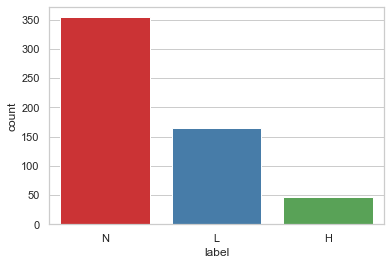

In [207]:
sns.countplot(x = 'label', data = labels_df, palette="Set1");

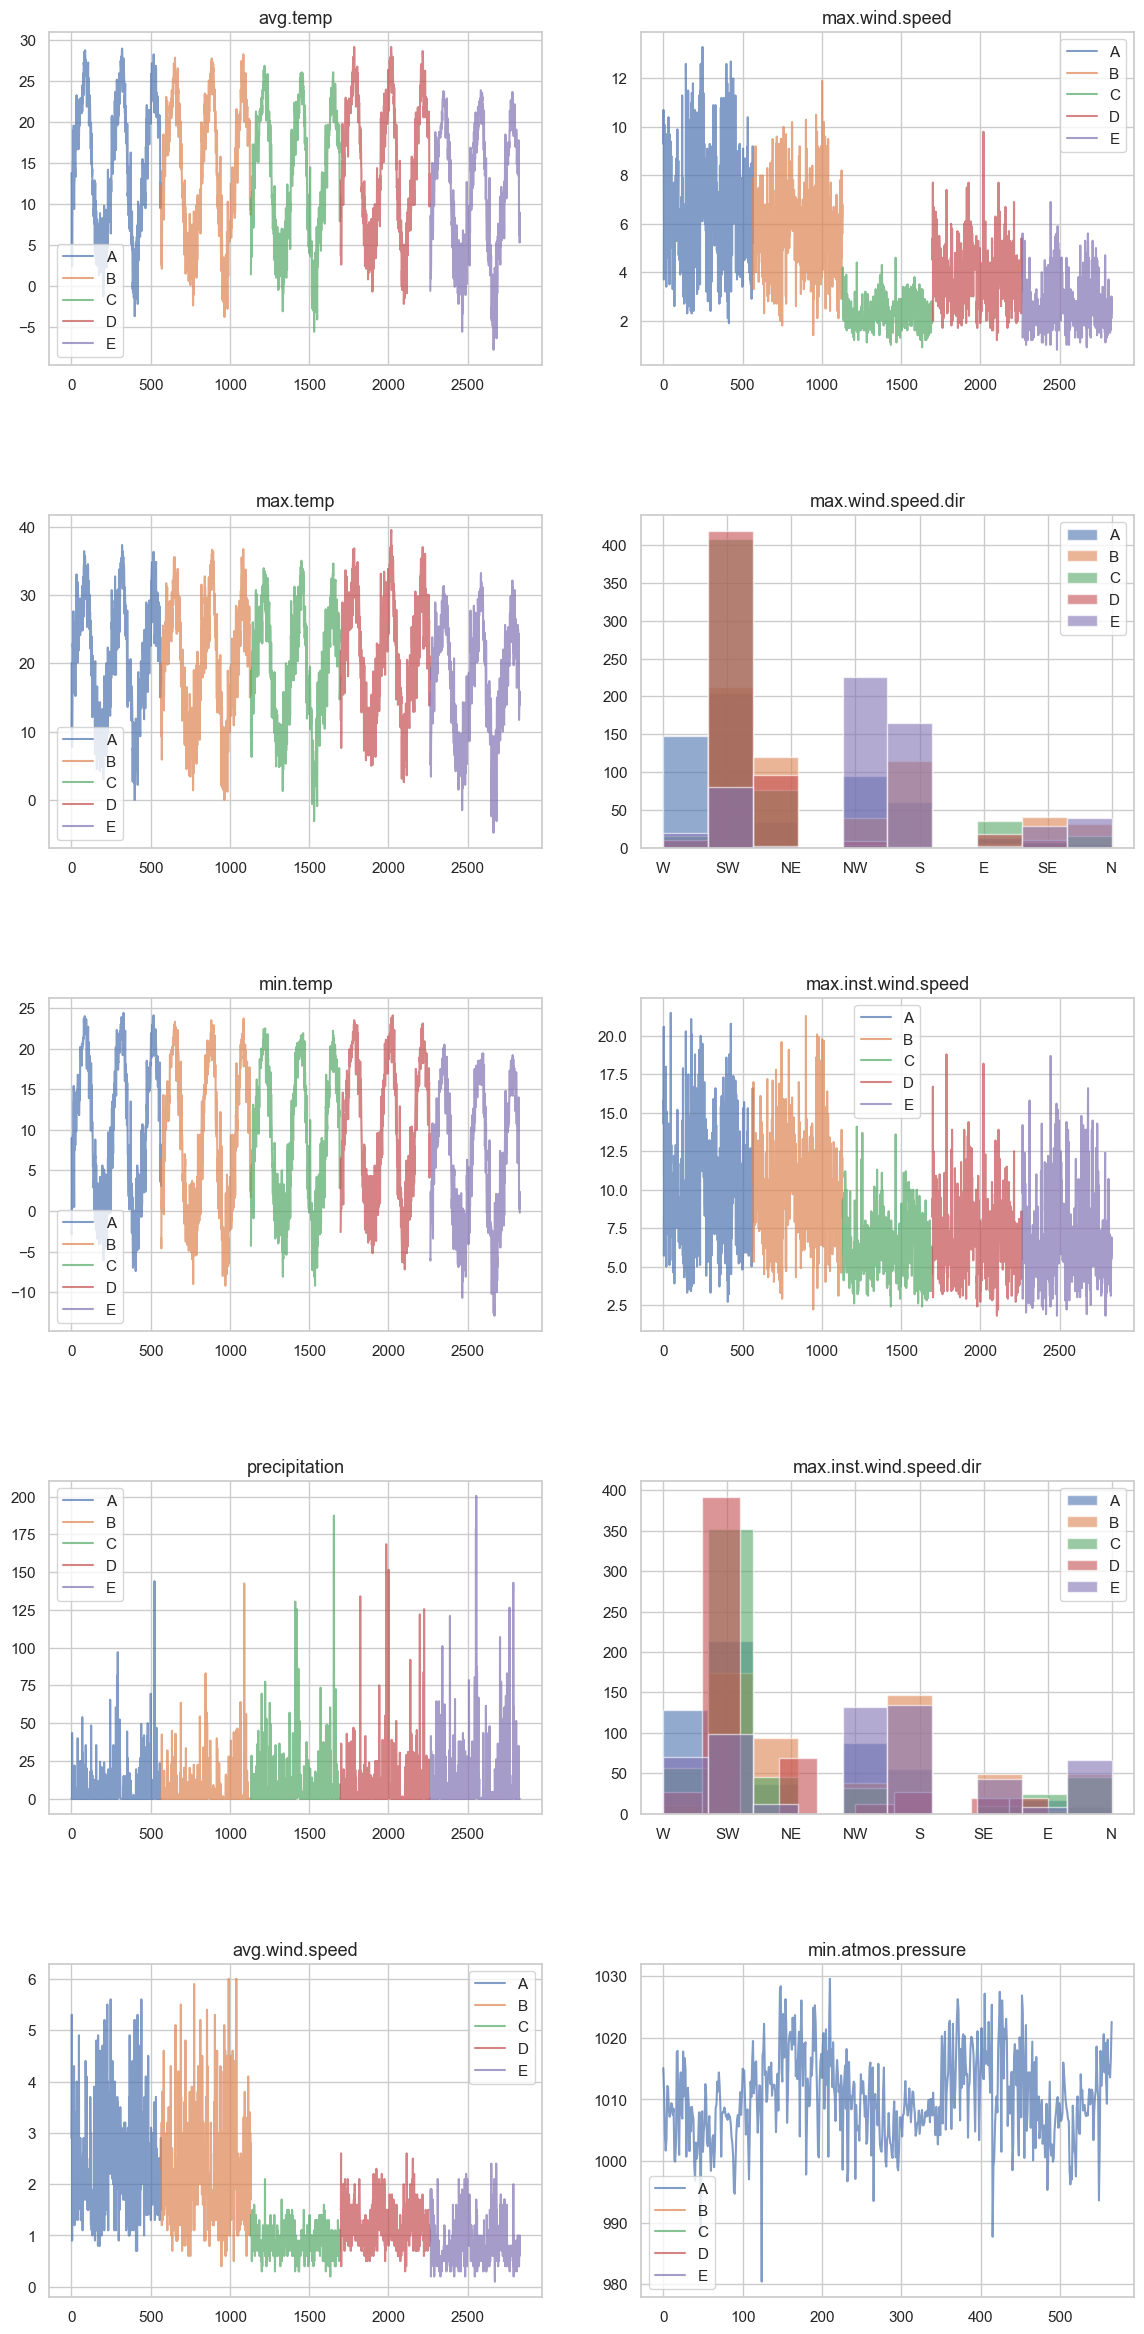

In [208]:
fig, axes = plt.subplots(5,2,figsize=(14, 30), dpi=100)

for i, col_name in enumerate(train_all_lvls.columns[2:]):
    if train_all_lvls[col_name].dtype == 'O':
        train_all_lvls.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.6);
        axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]);
    else:
        train_all_lvls.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
        axes[i%5][i//5].legend();
    axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
    plt.subplots_adjust(hspace=0.45)

In [209]:
test_all = pd.concat([train_a ,train_b ,train_c ,train_d ,train_e], keys=["A", "B", "C", "D", "E"])
test_all_lvls = test_all.reset_index()
test_all_lvls.rename(columns = {"level_0": "region"}, inplace=True)
test_all_lvls.drop(columns=['level_1'], inplace=True)
test_all_lvls.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,A,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,A,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,A,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,A,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5


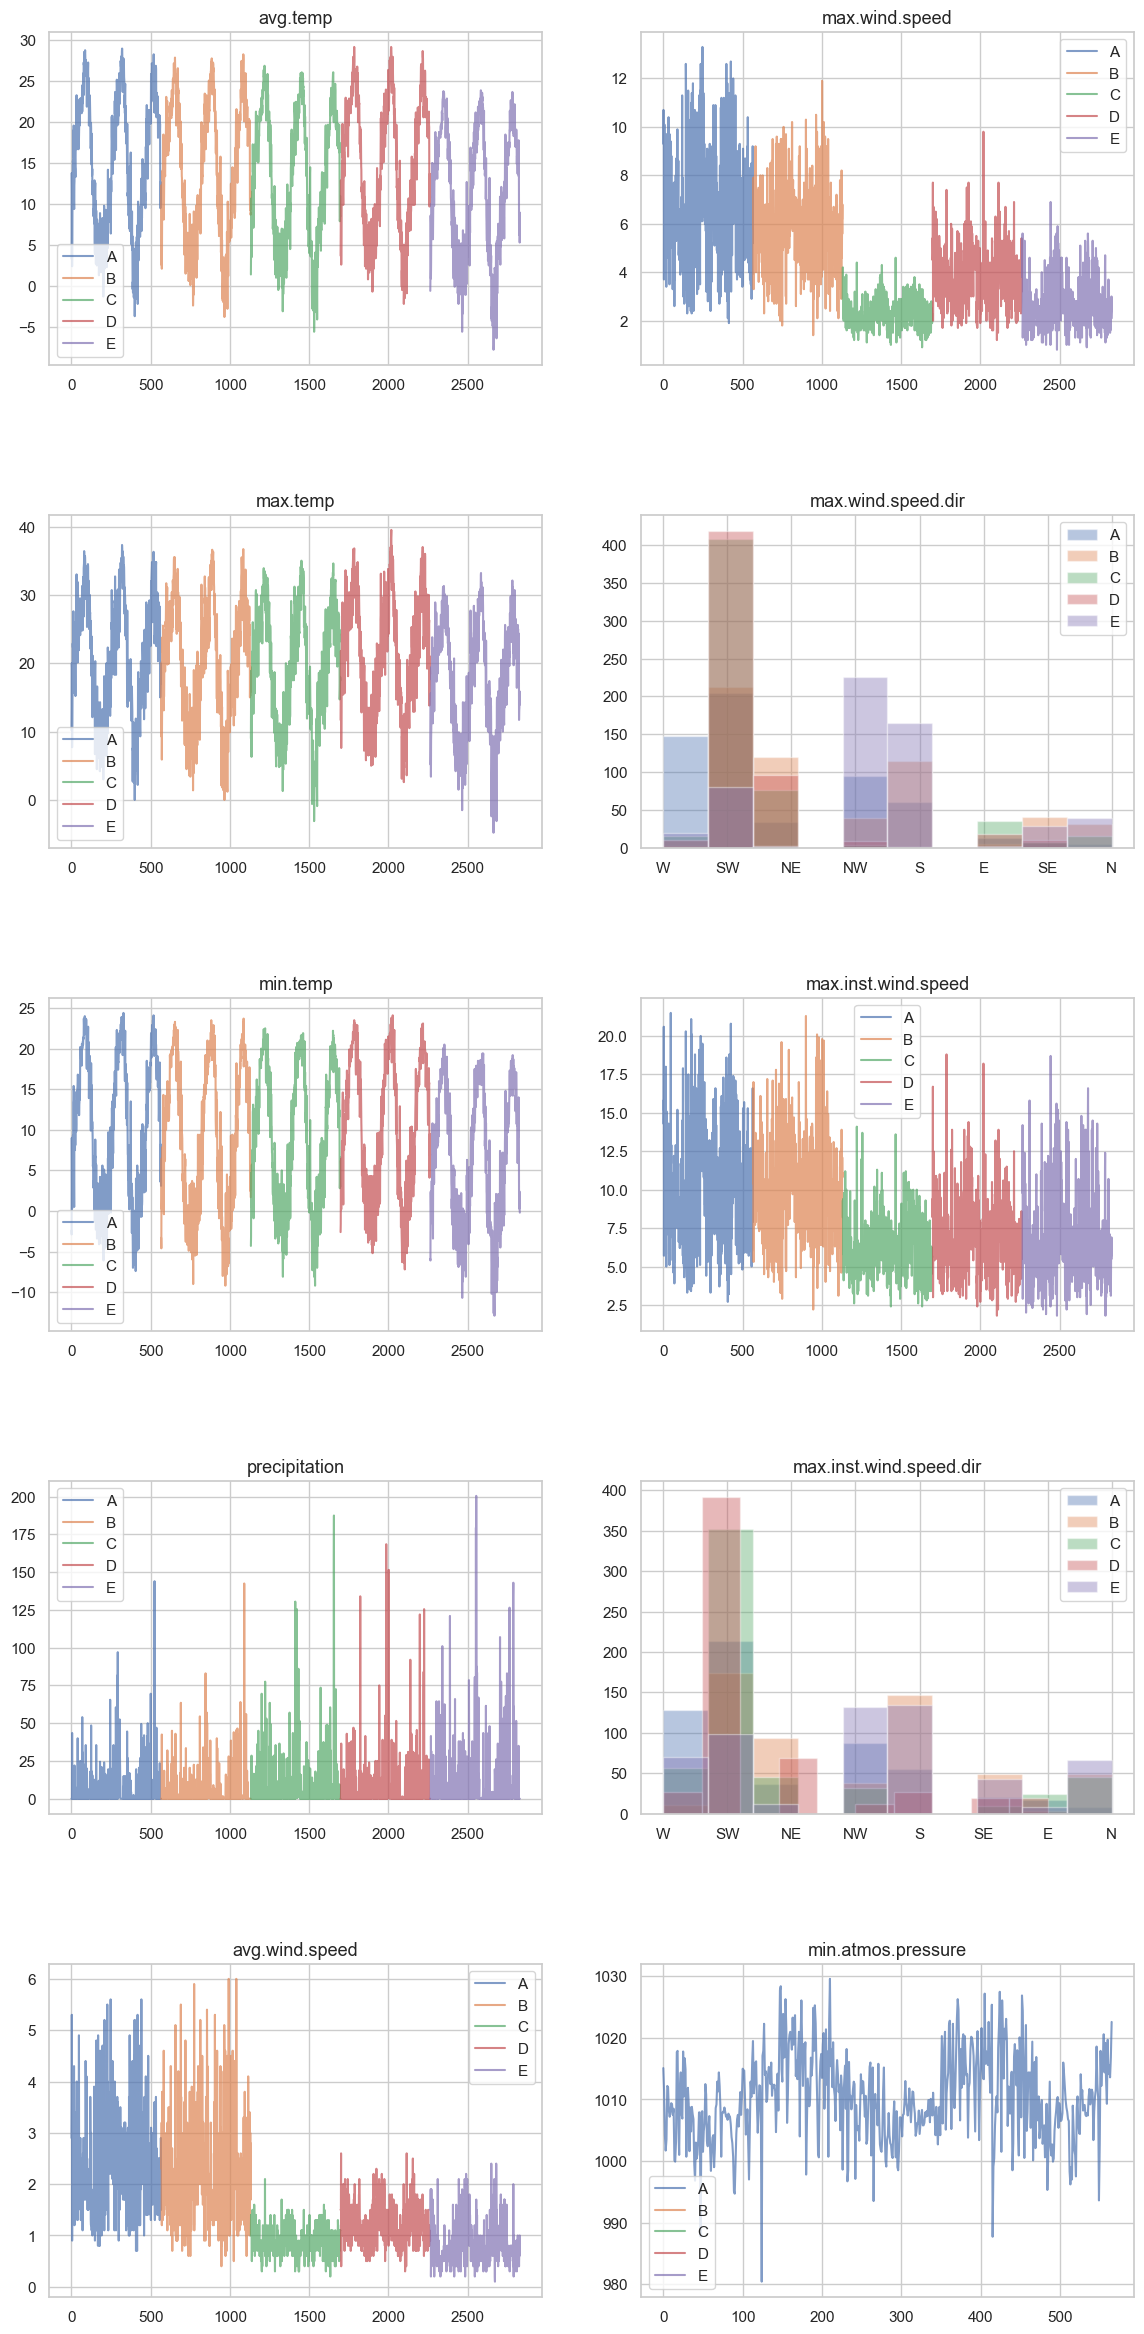

In [210]:
fig, axes = plt.subplots(5,2,figsize=(14, 30), dpi=100)

for i, col_name in enumerate(test_all_lvls.columns[2:]):
    if test_all_lvls[col_name].dtype == 'O':
        test_all_lvls.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.4);
        axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]);
    else:
        test_all_lvls.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
        axes[i%5][i//5].legend();
    axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
    plt.subplots_adjust(hspace=0.45)

## Missing Values

In [211]:
missing_cols(train_all_lvls)

min.atmos.pressure => 2264 [80.0%]


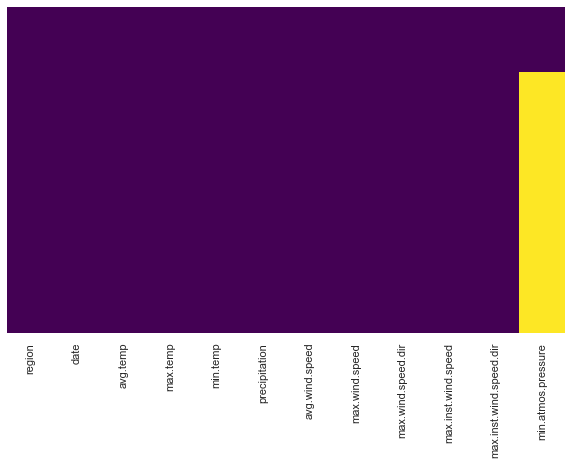

In [212]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_all_lvls.isnull(), yticklabels=False, cmap='viridis', cbar=False);

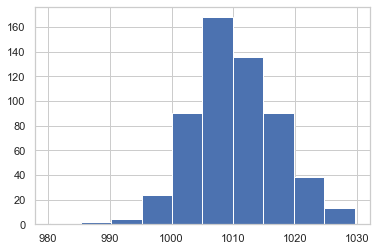

In [213]:
train_all_lvls['min.atmos.pressure'].hist();

In [214]:
mean_atmos = train_all_lvls['min.atmos.pressure'].mean()
train_all_lvls.fillna(mean_atmos, inplace=True)

In [215]:
missing_cols(train_all_lvls)

no missing values


In [216]:
missing_cols(test_all_lvls)

min.atmos.pressure => 2264 [80.0%]


In [217]:
mean_atmos = test_all_lvls['min.atmos.pressure'].mean()
test_all_lvls.fillna(mean_atmos, inplace=True)

In [218]:
missing_cols(test_all_lvls)

no missing values


## Feature Engineering

In [219]:
train_all_lvls = train_all_lvls.merge(labels_df, on="date")

In [220]:
train_all_lvls.dtypes

region                      object
date                        object
avg.temp                   float64
max.temp                   float64
min.temp                   float64
precipitation              float64
avg.wind.speed             float64
max.wind.speed             float64
max.wind.speed.dir          object
max.inst.wind.speed        float64
max.inst.wind.speed.dir     object
min.atmos.pressure         float64
label                       object
dtype: object

In [221]:
le = LabelEncoder()
le.fit(train_all_lvls['label'])
le_name_map = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_map

{'H': 0, 'L': 1, 'N': 2}

In [222]:
train_all_lvls.select_dtypes('object').columns

Index(['region', 'date', 'max.wind.speed.dir', 'max.inst.wind.speed.dir',
       'label'],
      dtype='object')

In [223]:
test_all_lvls.select_dtypes('object').columns

Index(['region', 'date', 'max.wind.speed.dir', 'max.inst.wind.speed.dir'], dtype='object')

In [224]:
train_all_lvls.groupby('region').describe()['avg.wind.speed']

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
A,566.0,2.377032,0.927039,0.7,1.7,2.3,2.9,5.6
B,566.0,2.277208,0.993604,0.4,1.5,2.1,2.8,6.0
C,566.0,0.912544,0.269516,0.2,0.7,0.9,1.1,2.1
D,566.0,1.238516,0.391051,0.3,1.0,1.2,1.5,2.6
E,566.0,0.840106,0.396890,0.1,0.6,0.7,1.0,2.4


In [225]:
train_all_lvls.groupby('region').describe()['max.wind.speed']

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
A,566.0,6.767491,2.221823,1.9,5.2,6.6,8.300,13.3
B,566.0,5.834806,1.711907,1.4,4.7,5.8,6.900,11.9
C,566.0,2.356184,0.600875,0.9,2.0,2.3,2.775,4.6
D,566.0,3.883392,1.204405,1.2,2.9,3.9,4.700,9.8
E,566.0,2.715724,0.978739,0.8,2.0,2.5,3.200,6.9


In [226]:
BEAUFORT = [
    (0, 0, 0.3),
    (1, 0.3, 1.6),
    (2, 1.6, 3.4),
    (3, 3.4, 5.5),
    (4, 5.5, 8),
    (5, 8, 10.8),
    (6, 10.8, 13.9),
    (7, 13.9, 17.2),
    (8, 17.2, 20.8),
    (9, 20.8, 24.5),
    (10, 24.5, 28.5),
    (11, 28.5, 33),
    (12, 33, 200),
]


def feature_eng(df):
    le = LabelEncoder()
    
    cat_cols = df.select_dtypes("object").columns[2:]

    for col in cat_cols:
        if df[col].dtype == "object":
            df[col] = le.fit_transform(df[col])

    # wind speed is in meter/second
    # convert to knots to obtain beaufort scale
    for item in BEAUFORT:
        df.loc[
            (df["avg.wind.speed"] * 1.944 >= item[1]) & (df["avg.wind.speed"] * 1.944 < item[2]),
            "avg_beaufort_scale",
        ] = item[0]
        df.loc[
            (df["max.wind.speed"] * 1.944 >= item[1]) & (df["max.wind.speed"] * 1.944 < item[2]),
            "max_beaufort_scale",
        ] = item[0]

    df['avg_beaufort_scale'] = df['avg_beaufort_scale'].astype(int)
    df['max_beaufort_scale'] = df['max_beaufort_scale'].astype(int)

    return df

In [227]:
train = feature_eng(train_all_lvls)
test = feature_eng(test_all_lvls)

## Prepare train data

In [228]:
train.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure,label,avg_beaufort_scale,max_beaufort_scale
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,7,14.3,7,1015.100000,2,4,8
1,B,229b70a3,2.6,9.3,-3.3,0.0,2.8,6.3,3,11.4,3,1010.216254,2,3,6
2,C,229b70a3,1.4,9.0,-4.3,0.0,1.0,2.9,6,8.2,1,1010.216254,2,2,4
3,D,229b70a3,3.7,11.7,-2.6,0.0,1.5,5.4,6,9.4,4,1010.216254,2,2,5
4,E,229b70a3,-0.6,5.2,-5.9,0.0,1.5,3.8,3,9.8,7,1010.216254,2,2,4


In [229]:
train.dtypes

region                      object
date                        object
avg.temp                   float64
max.temp                   float64
min.temp                   float64
precipitation              float64
avg.wind.speed             float64
max.wind.speed             float64
max.wind.speed.dir           int64
max.inst.wind.speed        float64
max.inst.wind.speed.dir      int64
min.atmos.pressure         float64
label                        int64
avg_beaufort_scale           int64
max_beaufort_scale           int64
dtype: object

In [230]:
train = train.pivot_table(index=["date", "label"], columns="region")
train = pd.DataFrame(train.to_records())
train.head()

,date,label,"('avg.temp', 'A')","('avg.temp', 'B')","('avg.temp', 'C')","('avg.temp', 'D')","('avg.temp', 'E')","('avg.wind.speed', 'A')","('avg.wind.speed', 'B')","('avg.wind.speed', 'C')",...,"('min.temp', 'A')","('min.temp', 'B')","('min.temp', 'C')","('min.temp', 'D')","('min.temp', 'E')","('precipitation', 'A')","('precipitation', 'B')","('precipitation', 'C')","('precipitation', 'D')","('precipitation', 'E')"
0,00173aec,2,18.7,17.6,16.9,19.5,14.3,1.6,1.8,0.9,...,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5
1,0083f291,1,13.1,12.6,12.0,13.0,10.7,1.4,1.0,0.7,...,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0
2,014cfe7b,2,19.9,19.0,17.5,19.9,16.2,3.7,3.6,0.7,...,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0
3,01947c8e,2,21.6,20.2,20.5,21.3,17.6,1.6,1.2,1.1,...,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0
4,0258884d,2,15.2,13.9,13.9,15.8,11.1,2.5,2.3,1.2,...,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0


In [231]:
def replace_all(text):
    d = { "('": "", "', '": "_", "')" : "",}
    for i, j in d.items():
        text = text.replace(i, j)
    return text

# ('avg.temp', 'A') -> avg.temp_A

test_str = "('avg.temp', 'A')"
replace_all(test_str)

'avg.temp_A'

In [232]:
train.columns = list(map(replace_all, train.columns))

In [233]:
train.columns

Index(['date', 'label', 'avg.temp_A', 'avg.temp_B', 'avg.temp_C', 'avg.temp_D',
       'avg.temp_E', 'avg.wind.speed_A', 'avg.wind.speed_B',
       'avg.wind.speed_C', 'avg.wind.speed_D', 'avg.wind.speed_E',
       'avg_beaufort_scale_A', 'avg_beaufort_scale_B', 'avg_beaufort_scale_C',
       'avg_beaufort_scale_D', 'avg_beaufort_scale_E', 'max.inst.wind.speed_A',
       'max.inst.wind.speed_B', 'max.inst.wind.speed_C',
       'max.inst.wind.speed_D', 'max.inst.wind.speed_E',
       'max.inst.wind.speed.dir_A', 'max.inst.wind.speed.dir_B',
       'max.inst.wind.speed.dir_C', 'max.inst.wind.speed.dir_D',
       'max.inst.wind.speed.dir_E', 'max.temp_A', 'max.temp_B', 'max.temp_C',
       'max.temp_D', 'max.temp_E', 'max.wind.speed_A', 'max.wind.speed_B',
       'max.wind.speed_C', 'max.wind.speed_D', 'max.wind.speed_E',
       'max.wind.speed.dir_A', 'max.wind.speed.dir_B', 'max.wind.speed.dir_C',
       'max.wind.speed.dir_D', 'max.wind.speed.dir_E', 'max_beaufort_scale_A',
       'max

In [234]:
test = test.pivot_table(index=["date"], columns="region")
test = pd.DataFrame(test.to_records())
test.columns = list(map(replace_all, test.columns))

In [235]:
train

,date,label,avg.temp_A,avg.temp_B,avg.temp_C,avg.temp_D,avg.temp_E,avg.wind.speed_A,avg.wind.speed_B,avg.wind.speed_C,...,min.temp_A,min.temp_B,min.temp_C,min.temp_D,min.temp_E,precipitation_A,precipitation_B,precipitation_C,precipitation_D,precipitation_E
0,00173aec,2,18.7,17.6,16.9,19.5,14.3,1.6,1.8,0.9,...,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5
1,0083f291,1,13.1,12.6,12.0,13.0,10.7,1.4,1.0,0.7,...,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0
2,014cfe7b,2,19.9,19.0,17.5,19.9,16.2,3.7,3.6,0.7,...,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0
3,01947c8e,2,21.6,20.2,20.5,21.3,17.6,1.6,1.2,1.1,...,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0
4,0258884d,2,15.2,13.9,13.9,15.8,11.1,2.5,2.3,1.2,...,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,fe2a1385,1,2.9,1.6,1.4,3.4,0.4,1.2,0.9,0.7,...,-4.0,-5.9,-2.8,-3.4,-5.9,0.0,0.0,0.0,0.0,0.0
562,fe6dd99c,1,2.9,2.9,3.9,2.9,0.2,1.6,3.9,1.0,...,1.7,1.4,1.9,1.0,-1.2,2.0,1.0,2.0,4.0,8.0
563,ff88c3dd,1,9.8,8.9,9.0,10.2,6.3,1.9,1.5,1.4,...,1.5,-0.1,2.0,2.5,-1.9,0.0,0.0,0.0,0.0,0.0
564,ff929090,2,10.4,8.1,7.1,11.0,5.7,4.3,4.6,0.9,...,3.4,1.5,-0.6,3.2,-1.6,0.0,3.5,5.5,0.0,1.5


In [236]:
test

,date,avg.temp_A,avg.temp_B,avg.temp_C,avg.temp_D,avg.temp_E,avg.wind.speed_A,avg.wind.speed_B,avg.wind.speed_C,avg.wind.speed_D,...,min.temp_A,min.temp_B,min.temp_C,min.temp_D,min.temp_E,precipitation_A,precipitation_B,precipitation_C,precipitation_D,precipitation_E
0,00173aec,18.7,17.6,16.9,19.5,14.3,1.6,1.8,0.9,1.2,...,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5
1,0083f291,13.1,12.6,12.0,13.0,10.7,1.4,1.0,0.7,0.7,...,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0
2,014cfe7b,19.9,19.0,17.5,19.9,16.2,3.7,3.6,0.7,1.3,...,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0
3,01947c8e,21.6,20.2,20.5,21.3,17.6,1.6,1.2,1.1,1.0,...,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0
4,0258884d,15.2,13.9,13.9,15.8,11.1,2.5,2.3,1.2,1.8,...,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,fe2a1385,2.9,1.6,1.4,3.4,0.4,1.2,0.9,0.7,0.9,...,-4.0,-5.9,-2.8,-3.4,-5.9,0.0,0.0,0.0,0.0,0.0
562,fe6dd99c,2.9,2.9,3.9,2.9,0.2,1.6,3.9,1.0,0.7,...,1.7,1.4,1.9,1.0,-1.2,2.0,1.0,2.0,4.0,8.0
563,ff88c3dd,9.8,8.9,9.0,10.2,6.3,1.9,1.5,1.4,1.5,...,1.5,-0.1,2.0,2.5,-1.9,0.0,0.0,0.0,0.0,0.0
564,ff929090,10.4,8.1,7.1,11.0,5.7,4.3,4.6,0.9,2.0,...,3.4,1.5,-0.6,3.2,-1.6,0.0,3.5,5.5,0.0,1.5


## Build the LightGBM model

In [237]:
train.dtypes

date                object
label                int64
avg.temp_A         float64
avg.temp_B         float64
avg.temp_C         float64
                    ...   
precipitation_A    float64
precipitation_B    float64
precipitation_C    float64
precipitation_D    float64
precipitation_E    float64
Length: 62, dtype: object

In [238]:
X, y = train.drop(["label", "date"], axis=1), train[["label"]].values.flatten()

In [239]:
# Extract categoricals and their indices
cat_feats = X.select_dtypes(include=['int64']).columns.to_list()
cat_idx = [X.columns.get_loc(col) for col in cat_feats]

In [240]:
# Convert cat_features to pd.Categorical dtype
for col in cat_feats:
    X[col] = pd.Categorical(X[col])

In [241]:
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, test_size=0.25, random_state=0)

## Model Prediction

In [242]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [243]:
y_pred=clf.predict(X_eval.values)

## Model performance

In [244]:
print(classification_report(y_pred, y_eval))

              precision    recall  f1-score   support

           0       0.33      0.75      0.46         4
           1       0.28      0.32      0.30        34
           2       0.80      0.72      0.76       104

    accuracy                           0.63       142
   macro avg       0.47      0.60      0.51       142
weighted avg       0.66      0.63      0.64       142



## Confusion matrix

In [245]:
class_names = le_name_map.keys()

Confusion matrix, without normalization
[[ 3  4  2]
 [ 1 12 26]
 [ 0 19 75]]
Normalized confusion matrix
[[0.33333333 0.44444444 0.22222222]
 [0.02564103 0.30769231 0.66666667]
 [0.         0.20212766 0.79787234]]


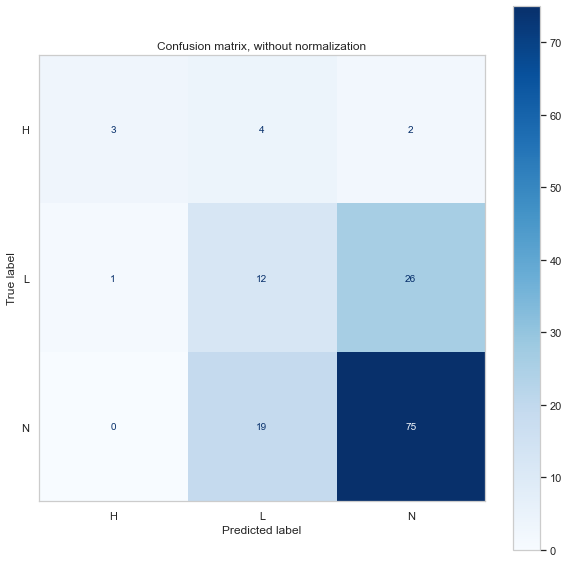

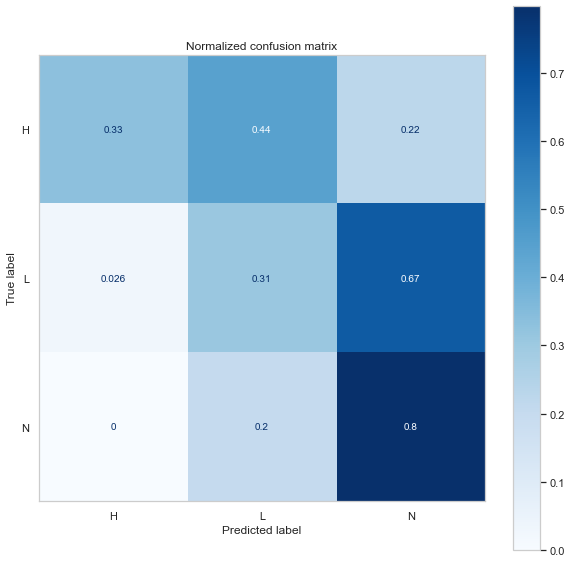

In [246]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))

    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_eval,
        y_eval,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

## Check for overfitting

In [185]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_eval, y_eval)))

Training set score: 1.0000
Test set score: 0.6338


## Feature importance

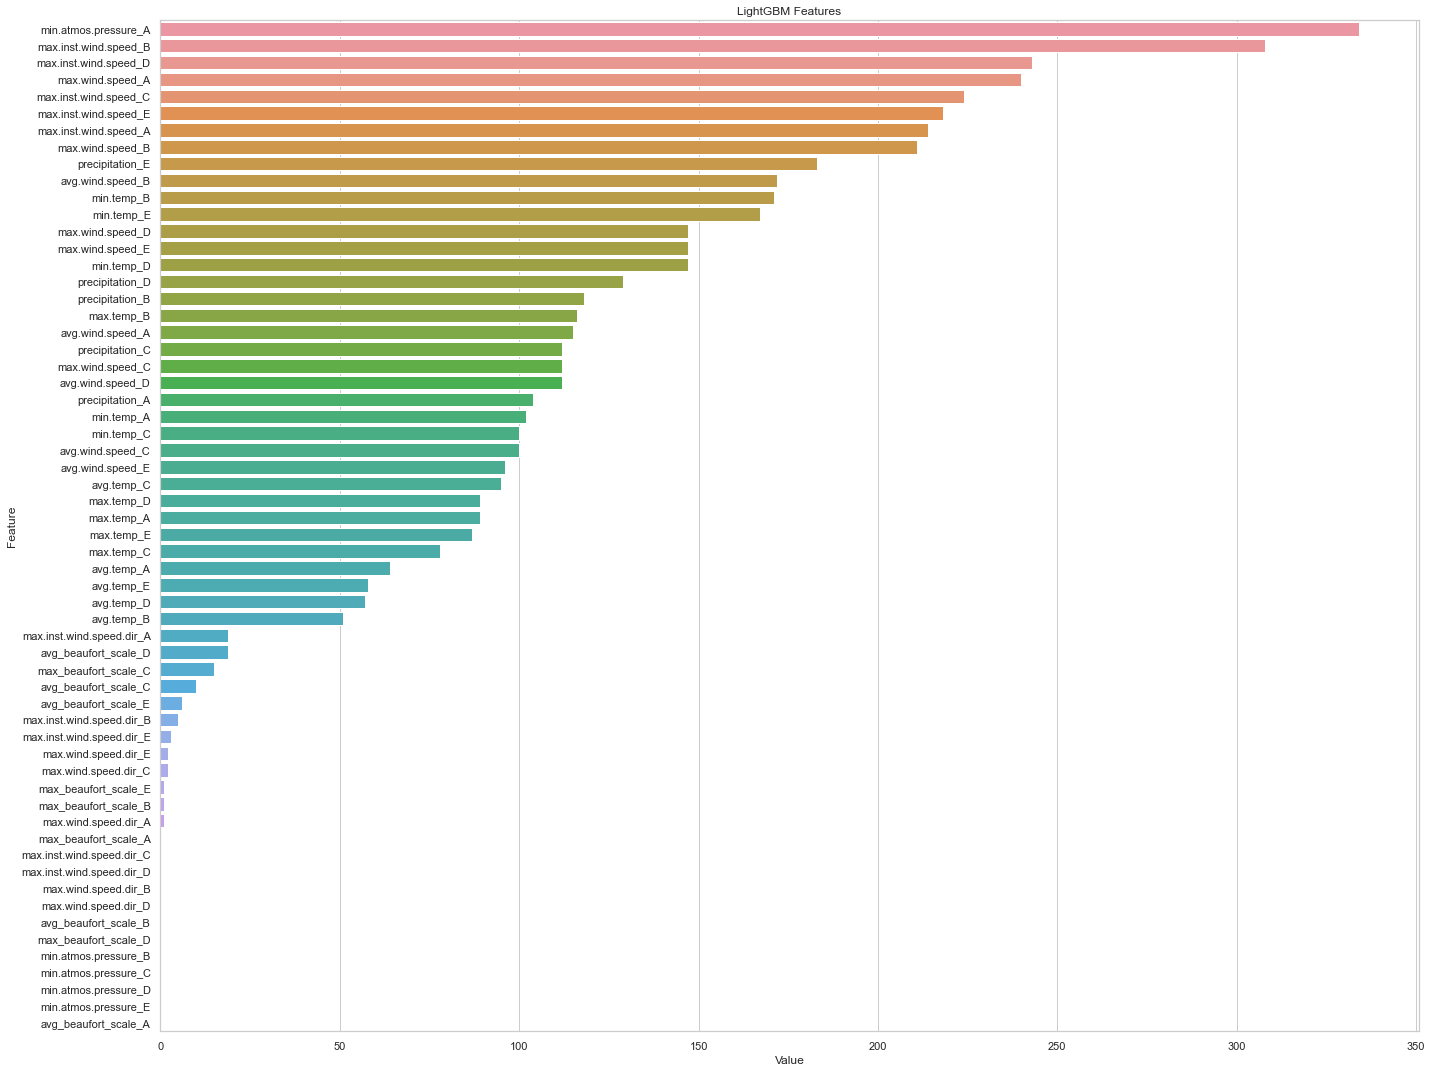

In [247]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
# plt.savefig('lightgbm_fimp.png')

## Save the model

In [248]:
# joblib.dump(clf, 'lgb1.pkl')

## Predict on test data

In [249]:
X = test.drop('date', axis=1)

In [250]:
# Convert cat_features to pd.Categorical dtype
for col in cat_feats:
    X[col] = pd.Categorical(X[col])

In [251]:
test_preds = clf.predict(X)
submission_df = pd.concat([test['date'], pd.DataFrame(test_preds, columns=['label'])], axis=1)
submission_df.head()

,date,label
0,00173aec,2
1,0083f291,1
2,014cfe7b,2
3,01947c8e,2
4,0258884d,2


In [252]:
le_name_map

{'H': 0, 'L': 1, 'N': 2}

In [253]:
inv_map = {v: k for k, v in le_name_map.items()}
inv_map

{0: 'H', 1: 'L', 2: 'N'}

In [254]:
submission_df['label'] = submission_df['label'].map(inv_map)  
submission_df.head()

,date,label
0,00173aec,N
1,0083f291,L
2,014cfe7b,N
3,01947c8e,N
4,0258884d,N


## Solution file

In [ ]:
submission_df.to_csv('solution.csv', index=False)